In [1]:
%load_ext autoreload
%autoreload 2

from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_time_plate_info_long_from_analysis 
from scipy.optimize import curve_fit

from amftrack.pipeline.final_analysis.density_wave import S
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *

import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.WARNING)
plates = ['94_20201123']
plate_select = [94]
import warnings
import scipy.stats as stats
import pandas as pd

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


C:\Users\coren\Documents\PhD\paper\travelling_wave\AMFTravellingWave\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
all_analysis_folders = get_analysis_folders("data")
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]

folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)
time_plate_info["time_since_begin"] = time_plate_info["time_since_begin"]/pd.Timedelta(hours = 1)
time_plate_info = time_plate_info.sort_values('time_since_begin')
time_plate_info['time_delta'] = -time_plate_info['time_since_begin'].diff(-1)
for index in range(20):
    time_plate_info[f"rhon-{index}"] = time_plate_info[f"ring_active_tips_density_incr-100_index-{index}"]*time_plate_info[f"ring_density_incr-100_index-{index}"]


folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)
folders,time_plate_info_long = get_time_plate_info_long_from_analysis(analysis_folders,use_saved=False)
for index in range(20):
    time_plate_info_long[f"rhon-{index}"] = time_plate_info_long[f"ring_active_tips_density_incr-100_index-{index}"]*time_plate_info[f"ring_density_incr-100_index-{index}"]


In [3]:
def find_t0(index,table):
    column = f"ring_density_incr-100_index-{index}"

    start = np.min(
        table.loc[table[column] >= 400]["time_since_begin"]
    )
    table[f"time_since_begin_{index}"] = (
        table["time_since_begin"] - start
    )

    area = np.sqrt(table["area_sep_comp"][0] + 100 * index)
    selection_fit = table
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    popt0, pcov = curve_fit(
        S,
        xis,
        yis,
        bounds=([0, 0, -np.inf], 3 * [np.inf]),
        p0=[1, 1, 0],
    )
    lamb, C, t0 = list(popt0)
    return(t0)

In [4]:
def plot_shade(df,xcolumn,ycolumn,color,ax):
    meancurve = df.groupby(xcolumn)[ycolumn].mean()
    stdcurve = df.groupby(xcolumn)[ycolumn].std()
    countcurve = df.groupby(xcolumn)[ycolumn].count()
    err = 2*stdcurve/np.sqrt(countcurve)
    ax.plot(meancurve.index,meancurve,color=color,linewidth = 1)
    ax.fill_between(meancurve.index, meancurve-err, meancurve+err,color=color,alpha = 0.4)
    return(meancurve)

In [5]:
for index in range(20):
    # time_plate_info_long[f"rhon-{index}"] = time_plate_info_long[f"ring_active_tips_density_incr-100_index-{index}"]*time_plate_info[f"ring_density_incr-100_index-{index}"]
    time_plate_info_long[f"rhon2-{index}"] = time_plate_info_long[f"ring_active_tips_density_incr-100_index-{index}"]*(time_plate_info[f"ring_density_incr-100_index-{index}"]-time_plate_info_long[f"ring_bas_density_incr-100_index-{index}"])**2


In [6]:
xcolumn = 'ts_round'

plate = 94

plt.close('all')
table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
table_rh = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate].copy()
lim = 100
# table = table.iloc[:lim]
# table_rh = table_rh.iloc[:lim]

ts = []

ys = []
ys2 = []
ys3 = []
ys4 = []
ys5 = []





# ax3.plot(meancurve3.index,meancurve3*meancurve4,linewidth = 5,color='green')


for index in range(15):
    column = f"ring_anas_density_incr-100_index-{index}"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"
    column3 = f"ring_branch_density_incr-100_index-{index}"
    column5 = f"ring_stop_density_incr-100_index-{index}"    
    column4 = f"rhon-{index}"
    
    start1 = np.min(table.loc[table[f"ring_density_incr-100_index-{index}"]>=400]['time_since_begin'])
    start = find_t0(index,table)+start1
    if not np.isnan(start):
        table[f'time_since_begin_{index}']=table['time_since_begin']-start
        # ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
        # ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

        ts +=table[f'time_since_begin_{index}'].to_list()
        ys += table_rh[column].astype(float).to_list()
        ys2+=table_rh[column2].astype(float).to_list()
        ys3+=table_rh[column3].astype(float).to_list()
        ys4+=(table_rh[column4].astype(float)/1000).to_list()
        ys5+=(table_rh[column5].astype(float)).to_list()
        
        
df = pd.DataFrame((np.array((ts,ys,ys2,ys3,ys4,ys5))).transpose(),columns=('ts','ys','ys2','ys3','ys4','ys5'))
factor = 4
df['ts_round'] = (df['ts']/factor).astype(int)*factor+factor/2


select = df.loc[df['ts_round'].between(-20,0)]
alpha = np.mean(select.groupby(xcolumn)['ys3'].mean()/select.groupby(xcolumn)['ys2'].mean())

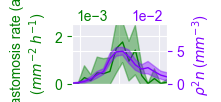

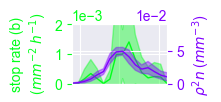

In [7]:
reduce = 1.3
width = 1.6/reduce
height = 1/reduce
purple = (0.5, 0.0, 1.0) 
green = (0,1,0.1)
plate = 94
plt.close('all')
table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
table_rh = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate].copy()
lim = 100
# table = table.iloc[:lim]
# table_rh = table_rh.iloc[:lim]

ts = []

ys = []
ys2 = []
ys3 = []
ys4 = []
ys5 = []





# ax3.plot(meancurve3.index,meancurve3*meancurve4,linewidth = 5,color='green')


for index in range(15):
    column = f"ring_anas_density_incr-100_index-{index}"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"
    column3 = f"ring_branch_density_incr-100_index-{index}"
    column5 = f"ring_stop_density_incr-100_index-{index}"    
    column4 = f"rhon2-{index}"
    
    start1 = np.min(table.loc[table[f"ring_density_incr-100_index-{index}"]>=400]['time_since_begin'])
    start = find_t0(index,table)+start1
    if not np.isnan(start):
        table[f'time_since_begin_{index}']=table['time_since_begin']-start
        # ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
        # ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

        ts +=table[f'time_since_begin_{index}'].to_list()
        ys += table_rh[column].astype(float).to_list()
        ys2+=table_rh[column2].astype(float).to_list()
        ys3+=table_rh[column3].astype(float).to_list()
        ys4+=(table_rh[column4].astype(float)/1e6).to_list()
        ys5+=(table_rh[column5].astype(float)).to_list()
        
        
df = pd.DataFrame((np.array((ts,ys,ys2,ys3,ys4,ys5))).transpose(),columns=('ts','ys','ys2','ys3','ys6','ys5'))
factor = 4
df['ts_round'] = (df['ts']/factor).astype(int)*factor+factor/2
xcolumn = 'ts_round'
# meancurve = df.groupby('ts_round')['ys'].mean()
# ax.plot(meancurve.index,meancurve,color="blue",linewidth = 5)



f, ax = plt.subplots(1, 1, sharex=True,figsize=(width,height))

# ax4.set_ylabel(r'branching density ($mm^{-2}.h^{-1}$)')
# plt.tight_layout()

ax3 = ax.twinx()
anas = plot_shade(df,xcolumn,'ys','green',ax)

rhon = plot_shade(df,xcolumn,'ys6',purple,ax3)
ax.set_ylabel('anastomosis rate (a) \n ($mm^{-2}$ $h^{-1}$)', color='green')

# ax.set_xlabel('shifted time, $t-t_n$ ($hour$)')
ax3.set_ylabel(r'$\rho^2 n$ ($mm^{-3}$)', color=purple)
ax.set_ylim((0,0.0025))
ax3.set_ylim((0,0.090))
ax.set_xticklabels([])

ax.tick_params(axis='y', colors='green')
ax3.tick_params(axis='y', colors=purple)
ax.set_xlim((-30,30))
ax.set_xticklabels([])

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.offsetText.set_position((0.05, 5))
ax3.yaxis.offsetText.set_position((0.95, 5))

f, ax4 = plt.subplots(1, 1, sharex=True,figsize=(width,height))
ax2 = ax4.twinx()

rhon = plot_shade(df,xcolumn,'ys6',purple,ax2)

branch = plot_shade(df,xcolumn,'ys5',green,ax4)
ax2.set_ylabel(r'$\rho^2 n$ ($mm^{-3}$)', color=purple)
ax4.set_ylabel('stop rate (b)\n ($mm^{-2}$ $h^{-1}$)', color=green)
ax2.set_xlabel('shifted time, $t-t_n$ ($h$)')

ax2.tick_params(axis='y', colors=purple)
ax4.tick_params(axis='y', colors=green)
ax4.set_ylim((0,0.002))

ax2.set_xlim((-30,30))
ax2.set_ylim((0,0.090))
ax2.set_xticklabels([])
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0))



Text(0.5, 0, 'shifted time, $t-t_n$ ($h$)')

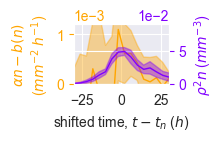

In [8]:

f, ax4 = plt.subplots(1, 1, sharex=True, figsize=(width, height))
df['residuals'] = alpha * df['ys2'] - df['ys3']
ax2 = ax4.twinx()

rhon = plot_shade(df, xcolumn, 'ys6', purple, ax2)
branch = plot_shade(df, xcolumn, 'residuals', 'orange', ax4)
ax2.set_ylabel(r'$\rho^2 n$ ($mm^{-3}$)', color=purple)
ax4.set_ylabel(r'$\alpha n -b(n)$' + '\n' + '($mm^{-2}$ $h^{-1}$)', color='orange')

ax2.tick_params(axis='y', colors=purple)
ax4.tick_params(axis='y', colors='orange')
ax4.set_ylim((0, 0.0012))

ax2.set_xlim((-30, 30))
ax2.set_ylim((0, 0.090))
# ax2.set_xticklabels([])
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax4.set_xlabel('shifted time, $t-t_n$ ($h$)')



Requires installing dolfin 2019.2.0.dev0 which cannot easily be done within a poetry environment. The following cell will only run with that specific version of dolfin installed. This can be done using something like (the right dolfin version could only be find in bvpy source files...)
```
conda env create -f env.yaml -n bvpy-dev
```

In [ ]:
%matplotlib widget
from dolfin import *
import numpy as nump
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

set_log_active(False)

cmap2 = mpl.cm.get_cmap("spring")
cmap = mpl.cm.get_cmap("winter")

# Define the problem
Length = 90.0
nx = 200
nT = 900
mesh = IntervalMesh(nx, 1, Length)
P1 = FiniteElement('P', interval, 1)
element = MixedElement([P1, P1])
V = FunctionSpace(mesh, element)

# Define the parameters
T = 150
dt = T/nT
alphval = 0.039
cval = 0.6
# Define the initial condition
u0 = Expression(('1*exp(-0.4*pow(abs(x[0]-10),1))',0), degree=1)

#define radial coordinate
rexp = Expression(('1/x[0]',0),degree=1)
r = interpolate(rexp, V)
invr, _ = split(r)
# Define other elements

u_n = interpolate(u0, V)
u = Function (V)
n, rho = split(u)
n_n, rho_n= split(u_n)
v_1, v_2 = TestFunctions(V)
k = Constant((1,))

s_scal = Constant(0.2)
beta = Constant(0.022)
alpha = Constant(alphval)
D = Constant(0.0007)

n_mid = 0.5*(n_n + n)
v_s_val = 0.235
v_s = Constant((v_s_val,))



F = n*v_1*dx - n_n*v_1*dx 
#Diffusion coefficient
F += D*dot(grad(n), grad(v_1))*dt*dx
F += dt*dot(grad(n_mid),v_s)*v_1*dx
# To account for cylindrical coordinates
F += invr*dt*n_mid*Constant(v_s_val)*v_1*dx

F -=dt*s_scal*n*v_2*dx-(rho-rho_n)*v_2*dx
F += beta*v_1*rho*(n)*dt*dx
F -= alpha*(n)*v_1*dt*dx

# Apply the boundary conditions
u_L = (Constant(0.0),Constant(0.0))
u_R = (Constant(0.0),Constant(0.0))
bc_L = DirichletBC(V, u_L, 'near(x[0], 1.0)')
bc_R = DirichletBC(V, u_R, f'near(x[0], {Length})')
bcs = [bc_L, bc_R]

# bc = PeriodicBC(V, Boundary())# Solve the problem
t = 0.0
a, L = lhs(F), rhs(F)
V2 = FunctionSpace(mesh, 'P', 1)
X = nump.linspace(1,Length,nx)
poss = []

fix,axs = plt.subplots(2,1)
i=0
for t in nump.linspace(0,T,nT):

    solve(F==0, u,bcs)
    u_n.assign(u)
    _n, _rho= u.split()
    n_field = interpolate(_n, V2)
    if i%150==0:
        rho_field = interpolate(_rho, V2)
        axs[0].plot(X,[n_field(x) for x in X],color=cmap2(t/T))
        axs[1].plot(X,[rho_field(x) for x in X],color=cmap(t/T))
    poss.append(nump.argmax([n_field(x) for x in X]))
    i+=1
    # break
axs[0].set_xlabel('')
axs[0].set_ylabel('$n (mm^{-2})$')

axs[1].set_xlabel('position ($mm$)')
axs[1].set_ylabel(r'$\rho (mm.mm^{-2})$')
x = nump.linspace(0,T,nT)
y = nump.array(poss)*Length/nx
fit_coeffs = nump.polyfit(x[3*nT//4:], y[3*nT//4:], 1)
fit_line = nump.polyval(fit_coeffs, x)

# Plot data and linear fit
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, fit_line, 'r--')
ax.set_xlabel('t (h)')
ax.set_ylabel('x ($mm$)')
print(fit_coeffs[0])

In [ ]:
%matplotlib widget
from dolfin import *
import numpy as nump
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
plt.close("all")
set_log_active(False)

cmap2 = mpl.cm.get_cmap("spring")
cmap = mpl.cm.get_cmap("winter")

# Define the problem
Length = 150.0
nx = 200
nT = 900
mesh = IntervalMesh(nx, 1, Length)
P1 = FiniteElement('P', interval, 1)
element = MixedElement([P1, P1])
V = FunctionSpace(mesh, element)

# Define the parameters
T = 400
dt = T/nT
alphval = 0.039
cval = 0.6
# Define the initial condition
u0 = Expression(('0.2*exp(-0.015*pow(abs(x[0]-10),2))',0), degree=1)
rexp = Expression(('1/x[0]',0),degree=1)
r = interpolate(rexp, V)
invr, _ = split(r)

# Define other elements

u_n = interpolate(u0, V)
u = Function (V)
n, rho = split(u)
n_n, rho_n= split(u_n)
v_1, v_2 = TestFunctions(V)
k = Constant((1,))

s_scal = Constant(0.2)
beta = Constant(0.02)
alpha = Constant(alphval)
D = Constant(0.55)

n_mid = 0.5*(n_n + n)
v_s = Constant((0,))

# Define the variational problem


F = n*v_1*dx - n_n*v_1*dx 
F += dt*dot(grad(n_mid),v_s)*v_1*dx
F += D*dot(grad(n), grad(v_1))*dt*dx
# To account for cylindrical coordinates
F += invr*D*dot(grad(n), Constant((1,)))*v_1*dt*dx

F -=dt*s_scal*n*v_2*dx-(rho-rho_n)*v_2*dx
F += beta*v_1*rho*(n)*dt*dx
F -= alpha*(n)*v_1*dt*dx
# Apply the boundary conditions
u_L = (Constant(0.0),Constant(0.0))
u_R = (Constant(0.0),Constant(0.0))
bc_L = DirichletBC(V, u_L, 'near(x[0], 1.0)')
bc_R = DirichletBC(V, u_R, f'near(x[0], {Length})')
bcs = [bc_L, bc_R]

# bc = PeriodicBC(V, Boundary())# Solve the problem
t = 0.0
a, L = lhs(F), rhs(F)
V2 = FunctionSpace(mesh, 'P', 1)
X = nump.linspace(1,Length,nx)
poss = []

fix,axs = plt.subplots(2,1)
i=0
for t in nump.linspace(0,T,nT):

    solve(F==0, u,bcs)
    u_n.assign(u)
    _n, _rho= u.split()
    n_field = interpolate(_n, V2)
    if i%150==0:
        rho_field = interpolate(_rho, V2)
        axs[0].plot(X,[n_field(x) for x in X],color=cmap2(t/T))
        axs[1].plot(X,[rho_field(x) for x in X],color=cmap(t/T))
    poss.append(nump.argmax([n_field(x) for x in X]))
    i+=1
    # break
axs[0].set_xlabel('')
axs[0].set_ylabel('$n (mm^{-2})$')

# axs[2].set_xlabel('position (x)')
# axs[2].set_ylabel('$n_p$')

axs[1].set_xlabel('position ($mm$)')
axs[1].set_ylabel(r'$\rho (mm.mm^{-2})$')

In [ ]:
x = nump.linspace(0,T,nT)
y = nump.array(poss)*Length/nx
fit_coeffs = nump.polyfit(x[3*nT//4:], y[3*nT//4:], 1)
fit_line = nump.polyval(fit_coeffs, x)

# Plot data and linear fit
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, fit_line, 'r--')
ax.set_xlabel('t (h)')
ax.set_ylabel('x ($mm$)')
fit_coeffs

In [ ]:
%matplotlib widget
from dolfin import *
import numpy as nump
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

plt.close("all")
set_log_active(False)

cmap2 = mpl.cm.get_cmap("spring")
cmap = mpl.cm.get_cmap("winter")

# Define the problem
Length = 40.0
nx = 200
nT = 900
mesh = IntervalMesh(nx, 1, Length)
P1 = FiniteElement('P', interval, 1)
element = MixedElement([P1, P1])
V = FunctionSpace(mesh, element)

# Define the parameters
T = 90
dt = T/nT
alphval = 0.039
cval = 0.6
# Define the initial condition
u0 = Expression(('0.8*exp(-0.1*pow(abs(x[0]-7),2))',0), degree=1)
#define radial coordinate
rexp = Expression(('1/x[0]',0),degree=1)
r = interpolate(rexp, V)
invr, _ = split(r)
# Define other elements

u_n = interpolate(u0, V)
u = Function (V)
n, rho = split(u)
n_n, rho_n= split(u_n)
v_1, v_2 = TestFunctions(V)
k = Constant((1,))

s_scal = Constant(0.2)
beta = Constant(0.022)
alpha = Constant(alphval)
D = Constant(0.02)

n_mid = 0.5*(n_n + n)
v_sval = 0.235
v_s = Constant((v_sval,))


F = n*v_1*dx - n_n*v_1*dx 
#Diffusion coefficient
F += D*dot(grad(n), grad(v_1))*dt*dx
# To account for cylindrical coordinates
F += invr*D*dot(grad(n), Constant((1,)))*v_1*dt*dx
F += dt*dot(grad(n_mid),v_s)*v_1*dx
# To account for cylindrical coordinates
F += invr*dt*n_mid*Constant(v_sval)*v_1*dx



F -=dt*s_scal*n*v_2*dx-(rho-rho_n)*v_2*dx
F += beta*v_1*rho*(n)*dt*dx
F -= alpha*(n)*v_1*dt*dx

# Apply the boundary conditions
u_L = (Constant(0.0),Constant(0.0))
u_R = (Constant(0.0),Constant(0.0))
bc_L = DirichletBC(V, u_L, 'near(x[0], 1.0)')
bc_R = DirichletBC(V, u_R, f'near(x[0], {Length})')
bcs = [bc_L, bc_R]

# bc = PeriodicBC(V, Boundary())# Solve the problem
t = 0.0
a, L = lhs(F), rhs(F)
V2 = FunctionSpace(mesh, 'P', 1)
X = nump.linspace(1,Length,nx)
poss = []

fix,axs = plt.subplots(2,1)
i=0
for t in nump.linspace(0,T,nT):

    solve(F==0, u,bcs)
    u_n.assign(u)
    _n, _rho= u.split()
    n_field = interpolate(_n, V2)
    if i%150==0:
        rho_field = interpolate(_rho, V2)
        axs[0].plot(X,[n_field(x) for x in X],color=cmap2(t/T))
        axs[1].plot(X,[rho_field(x) for x in X],color=cmap(t/T))
    poss.append(nump.argmax([n_field(x) for x in X]))
    i+=1
    # break
axs[0].set_xlabel('')
axs[0].set_ylabel('$n (mm^{-2})$')

axs[1].set_xlabel('position ($mm$)')
axs[1].set_ylabel(r'$\rho (mm.mm^{-2})$')

In [ ]:
x = nump.linspace(0,T,nT)
y = nump.array(poss)*Length/nx
fit_coeffs = nump.polyfit(x[3*nT//4:], y[3*nT//4:], 1)
fit_line = nump.polyval(fit_coeffs, x)

# Plot data and linear fit
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, fit_line, 'r--')
ax.set_xlabel('t (h)')
ax.set_ylabel('x ($mm$)')

In [ ]:
%matplotlib widget
from dolfin import *
import numpy as nump
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

plt.close("all")
set_log_active(False)

cmap2 = mpl.cm.get_cmap("spring")
cmap = mpl.cm.get_cmap("winter")

# Define the problem
Length = 40.0
nx = 200
nT = 900
mesh = IntervalMesh(nx, 1, Length)
P1 = FiniteElement('P', interval, 1)
element = MixedElement([P1, P1,P1])
V = FunctionSpace(mesh, element)

# Define the parameters
b = Constant(1.0)
T = 90
dt = T/nT
alphval = 0.039
cval = 0.6
# Define the initial condition
u0 = Expression(('1*exp(-0.2*pow(abs(x[0]-5),2))','0.65*exp(-0.2*pow(abs(x[0]-5),2))',0), degree=1)
rexp = Expression(('1/x[0]',0,0),degree=1)
r = interpolate(rexp, V)
invr, _, _ = split(r)
u_n = interpolate(u0, V)
u = Function (V)
n,np, rho = split(u)
n_n,np_n, rho_n= split(u_n)
v_1, v_0,v_2 = TestFunctions(V)
s_scal_pull = Constant(0.3)

sp = Constant((s_scal_pull,))
k = Constant((1,))

s_scal = Constant(0.22)

beta = Constant(0.022)
alpha = Constant(alphval)
D = Constant(0.02)
alphantonp = Constant(0.25)
alphanpton = Constant(0.40)


np_mid = 0.5*(np_n + np)
n_mid = 0.5*(n_n + n)
np_mid = np
n_mid = n
# v_s = vmin+(vmax-vmin)*(1-rho/(4*alpha/beta))
v_sval = 0.2
v_s = Constant((v_sval,))


# Define the variational problem
# F = (u - u_n)*v*dx + dt*b*dot(grad(u_mid),s)*v*dx
F = n*v_1*dx - n_n*v_1*dx 
F += dt*dot(grad(n_mid),v_s)*v_1*dx
# To account for cylindrical coordinates

# F += invr*dt*n_mid*Constant(v_sval)*v_1*dx

F -=dt*s_scal*n*v_2*dx-(rho-rho_n)*v_2*dx+dt*s_scal_pull*np*v_2*dx
F += beta*v_1*rho*(n_mid)*dt*dx
F -= alpha*(n_mid)*v_1*dt*dx
F += alphantonp*(n_mid)*v_1*dt*dx
F -= alphanpton*(np)*v_1*dt*dx

F += np*v_0*dx + dt*dot(grad(np_mid),sp)*v_0*dx- (np_n)*v_0*dx 
# To account for cylindrical coordinates

# F += invr*dt*np_mid*Constant(s_scal_pull)*v_0*dx

F -= alphantonp*(n_mid)*v_0*dt*dx
F += alphanpton*(np)*v_0*dt*dx
F -= alpha*(np)*v_0*dt*dx
# F += beta*v_0*rho*(np)*dt*dx

# F += 0.1*np*v_0*dt*dx
# Apply the boundary conditions
u_L = (Constant(0.0),Constant(0.0),Constant(0.0))
u_R = (Constant(0.0),Constant(0.0),Constant(0.0))
bc_L = DirichletBC(V, u_L, 'near(x[0], 1.0)')
bc_R = DirichletBC(V, u_R, f'near(x[0], {Length})')
bcs = [bc_L, bc_R]

# bc = PeriodicBC(V, Boundary())# Solve the problem
t = 0.0
a, L = lhs(F), rhs(F)
V2 = FunctionSpace(mesh, 'P', 1)
X = nump.linspace(1,Length,nx)
poss = []

fix,axs = plt.subplots(3,1)
i=0
for t in nump.linspace(0,T,nT):

    solve(F==0, u,bcs)
    u_n.assign(u)
    _n,_n_p, _rho= u.split()
    n_field = interpolate(_n, V2)
    if i%150==0:
        rho_field = interpolate(_rho, V2)
        np_field = interpolate(_n_p, V2)
        axs[0].plot(X,[n_field(x) for x in X],color=cmap2(t/T))
        
        # axs[0].set_yscale('log')
        axs[2].plot(X,[rho_field(x) for x in X],color=cmap(t/T))
        axs[1].plot(X,[np_field(x) for x in X],color=cmap2(t/T))
    poss.append(nump.argmax([n_field(x) for x in X]))
    i+=1
    # break
axs[0].set_xlabel('',size=14)
axs[0].set_ylabel('$n (mm^{-2})$')

axs[2].set_xlabel('position ($mm$)')
axs[1].set_ylabel('$n_{puller}(mm^{-2})$')
axs[1].set_xlabel('',size=14)
axs[2].set_ylabel(r'$\rho (mm.mm^{-2})$')   

In [ ]:
x = nump.linspace(0,T,nT)
y = nump.array(poss)*Length/nx
fit_coeffs = nump.polyfit(x[3*nT//4:], y[3*nT//4:], 1)
fit_line = nump.polyval(fit_coeffs, x)

# Plot data and linear fit
fig, ax = plt.subplots(figsize=(width/3,height/2))
ax.plot(x, y)
ax.plot(x, fit_line, 'r--')
ax.set_xlabel('t (h)')
ax.set_ylabel('x ($mm$)')

In [ ]:
%matplotlib widget
from dolfin import *
import numpy as nump
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

plt.close("all")
set_log_active(False)

cmap2 = mpl.cm.get_cmap("spring")
cmap = mpl.cm.get_cmap("winter")

# Define the problem
Length = 40.0
nx = 200
nT = 900
mesh = IntervalMesh(nx, 1, Length)
P1 = FiniteElement('P', interval, 1)
element = MixedElement([P1, P1])
V = FunctionSpace(mesh, element)

# Define the parameters
T = 90
dt = T/nT
alphval = 0.039
cval = 0.6
# Define the initial condition
u0 = Expression(('0.6*exp(-0.3*pow(abs(x[0]-7),2))',0), degree=1)
rexp = Expression(('1/x[0]',0),degree=1)
r = interpolate(rexp, V)
invr, _ = split(r)

u_n = interpolate(u0, V)
u = Function (V)
n, rho = split(u)
n_n, rho_n= split(u_n)
v_1, v_2 = TestFunctions(V)
k = Constant((1,))

s_scal = Constant(0.2)
beta = Constant(0.074)
alpha = Constant(alphval)
D = Constant(0.02)

n_mid = 0.5*(n_n + n)
v_sval = 0.235
v_s = Constant((v_sval,))



F = n*v_1*dx - n_n*v_1*dx 
#Diffusion coefficient
F += D*dot(grad(n), grad(v_1))*dt*dx
# To account for cylindrical coordinates
F += invr*D*dot(grad(n), Constant((1,)))*v_1*dt*dx
F += dt*dot(grad(n_mid),v_s)*v_1*dx
# To account for cylindrical coordinates
F += invr*dt*n_mid*Constant(v_sval)*v_1*dx

F -=dt*s_scal*n*v_2*dx-(rho-rho_n)*v_2*dx
F += beta*v_1*rho**2*(n)*dt*dx
F -= alpha*(n)*v_1*dt*dx
# Apply the boundary conditions
u_L = (Constant(0.0),Constant(0.0))
u_R = (Constant(0.0),Constant(0.0))
bc_L = DirichletBC(V, u_L, 'near(x[0], 1.0)')
bc_R = DirichletBC(V, u_R, f'near(x[0], {Length})')
bcs = [bc_L, bc_R]

# bc = PeriodicBC(V, Boundary())# Solve the problem
t = 0.0
a, L = lhs(F), rhs(F)
V2 = FunctionSpace(mesh, 'P', 1)
X = nump.linspace(1,Length,nx)
poss = []

fix,axs = plt.subplots(2,1)
i=0
for t in nump.linspace(0,T,nT):

    solve(F==0, u,bcs)
    u_n.assign(u)
    _n, _rho= u.split()
    n_field = interpolate(_n, V2)
    if i%150==0:
        rho_field = interpolate(_rho, V2)
        axs[0].plot(X,[n_field(x) for x in X],color=cmap2(t/T))
        axs[1].plot(X,[rho_field(x) for x in X],color=cmap(t/T))
    poss.append(nump.argmax([n_field(x) for x in X]))
    i+=1
    # break
axs[0].set_xlabel('')
axs[0].set_ylabel('$n (mm^{-2})$')

# axs[2].set_xlabel('position (x)')
# axs[2].set_ylabel('$n_p$')

axs[1].set_xlabel('position ($mm$)')
axs[1].set_ylabel(r'$\rho (mm.mm^{-2})$')

In [ ]:
x = nump.linspace(0,T,nT)
y = nump.array(poss)*Length/nx
fit_coeffs = nump.polyfit(x[3*nT//4:], y[3*nT//4:], 1)
fit_line = nump.polyval(fit_coeffs, x)

# Plot data and linear fit
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, fit_line, 'r--')
ax.set_xlabel('t (h)')
ax.set_ylabel('x ($mm$)')